## Integrating momentum with SGD :-

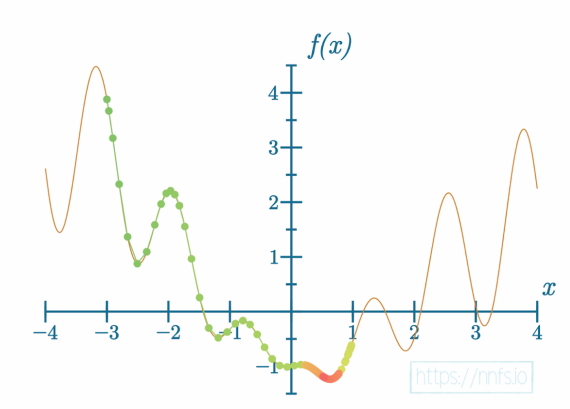

##### This is how  model learns the position about global minima and hence, the best parameters (w, b)

In [2]:
# we will use data of spiral data
def spiral_data(samples, classes):
    X = np.zeros((samples*classes, 2))
    y = np.zeros(samples*classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(samples*class_number, samples*(class_number+1))
        r = np.linspace(0.0, 1, samples)
        t = np.linspace(class_number*4, (class_number+1)*4, samples) + np.random.randn(samples)*0.2
        X[ix] = np.c_[r*np.sin(t*2.5), r*np.cos(t*2.5)]
        y[ix] = class_number
    return X, y

In [3]:
import numpy as np

In [4]:
class Layer_Dense:
# Layer initialization
    def __init__(self, n_inputs, n_neurons):
# Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
# Forward pass
    def forward(self, inputs):
# Remember input values
        self.inputs = inputs
# Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
# Backward pass
    def backward(self, dvalues):
# Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
# Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [5]:
# ReLU activation
class Activation_ReLU:
# Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
# Calculate output values from inputs
        self.output = np.maximum(0, inputs)
    def backward(self, dvalues):
# Since we need to modify original variable,
# let's make a copy of values first
        self.dinputs = dvalues.copy()
# Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

In [6]:
# Softmax activation
class Activation_Softmax:
# Forward pass
    def forward(self, inputs):
# Remember input values
        self.inputs = inputs
# Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,keepdims=True))
# Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
        self.output = probabilities
# Backward pass
    def backward(self, dvalues):
# Create uninitialized array
        self.dinputs = np.empty_like(dvalues)
# Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
# Flatten output array
            single_output = single_output.reshape(-1, 1)
# Calculate Jacobian matrix of the output and
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
# Calculate sample-wise gradient
# and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,single_dvalues)

In [7]:
# Common loss class
class Loss:
# Calculates the data and regularization losses
# given model output and ground truth values
    def calculate(self, output, y):
# Calculate sample losses
        sample_losses = self.forward(output, y)
# Calculate mean loss
        data_loss = np.mean(sample_losses)
# Return loss
        return data_loss

In [8]:
class Loss_CategoricalCrossentropy(Loss):
# Forward pass
    def forward(self, y_pred, y_true):
# Number of samples in a batch
        samples = len(y_pred)
# Clip data to prevent division by 0
# Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
# Probabilities for target values -
# only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples),y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true,axis=1)
# Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
# Backward pass
    def backward(self, dvalues, y_true):
# Number of samples
        samples = len(dvalues)
# Number of labels in every sample
# We'll use the first sample to count them
        labels = len(dvalues[0])
# If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
# Calculate gradient
        self.dinputs = -y_true / dvalues
# Normalize gradient
        self.dinputs = self.dinputs / samples


In [9]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
# Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
# Forward pass
    def forward(self, inputs, y_true):
# Output layer's activation function
        self.activation.forward(inputs)
# Set the output
        self.output = self.activation.output
# Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
# Number of samples
        samples = len(dvalues)
# If labels are one-hot encoded,
# turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
# Copy so we can safely modify
        self.dinputs = dvalues.copy()
# Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
# Normalize gradient
        self.dinputs = self.dinputs / samples


In [10]:
# SGD optimizer
class Optimizer_SGD:
# Initialize optimizer - set settings,
# learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
# Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
# Update parameters
    def update_params(self, layer):
# If we use momentum
        if self.momentum:
# If layer does not contain momentum arrays, create them
# filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
# If there is no momentum array for weights
# The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)
# Build weight updates with momentum - take previous
# updates multiplied by retain factor and update with
# current gradients
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
# Build bias updates
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        
# Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
# Update weights and biases using either
# vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates
# Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

In [15]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer
optimizer = Optimizer_SGD(learning_rate=1, decay=1e-3, momentum=0.9)
# Train in loop
for epoch in range(10001):
# Perform a forward pass of our training data through this layer
    dense1.forward(X)
# Perform a forward pass through activation function
# takes the output of first dense layer here
    activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')
# Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
# Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.410, loss: 1.099, lr: 1
epoch: 100, acc: 0.433, loss: 1.035, lr: 0.9099181073703367
epoch: 200, acc: 0.400, loss: 1.160, lr: 0.8340283569641367
epoch: 300, acc: 0.630, loss: 0.785, lr: 0.7698229407236336
epoch: 400, acc: 0.700, loss: 0.634, lr: 0.7147962830593281
epoch: 500, acc: 0.740, loss: 0.583, lr: 0.66711140760507
epoch: 600, acc: 0.783, loss: 0.497, lr: 0.6253908692933083
epoch: 700, acc: 0.770, loss: 0.459, lr: 0.5885815185403178
epoch: 800, acc: 0.847, loss: 0.374, lr: 0.5558643690939411
epoch: 900, acc: 0.820, loss: 0.436, lr: 0.526592943654555
epoch: 1000, acc: 0.870, loss: 0.331, lr: 0.5002501250625312
epoch: 1100, acc: 0.873, loss: 0.324, lr: 0.4764173415912339
epoch: 1200, acc: 0.873, loss: 0.329, lr: 0.45475216007276037
epoch: 1300, acc: 0.907, loss: 0.263, lr: 0.43497172683775553
epoch: 1400, acc: 0.847, loss: 0.311, lr: 0.4168403501458941
epoch: 1500, acc: 0.903, loss: 0.250, lr: 0.4001600640256102
epoch: 1600, acc: 0.870, loss: 0.282, lr: 0.3847633705